## Non-parametric clustering of genomics data
Next generation sequencing [1] is causing an explosion in the amount of data generated by the field of genomics. The field is ripe for analysis with the tools of Big Data and Data Science. 

For dealing with data in my current field of biophysics, I've recently developed an obsession with the subset of unsupervised learning known as clustering. Specifically, I'm interested in clustering techniques that either don't require arbitrary parameter selection or can be adapted to eliminate the need for a human to make a choice. Rather than having a user select parameters for analyzing the data, I want the data to speak for itself.

This summer, my research group (http://salsburygroup.squarespace.com/) submitted a paper [2] on two modern clustering techniques -- HDBSCAN and Amorim-Hennig -- applied to Molecular Dynamics (MD) data. In MD, we simulate the movement of small molecules using classical physics (no quantum mechanics). These simulations generate hundreds of gigabytes worth of data -- far more than a person could ever sift through. 

With the relatively close relationships between biophysics (my field) and genomics, my advisor suggested applying these clustering techniques to gene expression data with the hope of identifying patient subtypes without the need for any arbitrary parameter setting by a human. 

The initial results are negative. The two non-parametric clustering techniques that worked well for MD [2], perform essentially as well as random selection on genomics data. Using six small, (~100 samples each) labeled,  publicly available data from the Broad Institute's Cancer Program  http://portals.broadinstitute.org/cgi-bin/cancer/datasets.cgi, I clustered multiple sets of gene expression data from cancer patients using three clustering techniques available in Scikt-Learn [3] along with the two techniques discussed in my paper [2]. Since the data from the Broad Institute was labeled, I was able to score the clustering algorithms on how well they did relative to the true categories in the data, using the Adjusted Rand Index [4]. Since the results are negative and unlikely to be published otherwise, I report them here.

./raw_data/DLBCL_D.gct
./raw_data/Multi_B.gct
./raw_data/Breast_B.gct
./raw_data/Breast_A.gct
./raw_data/DLBCL_C.gct
./raw_data/Multi_A.gct


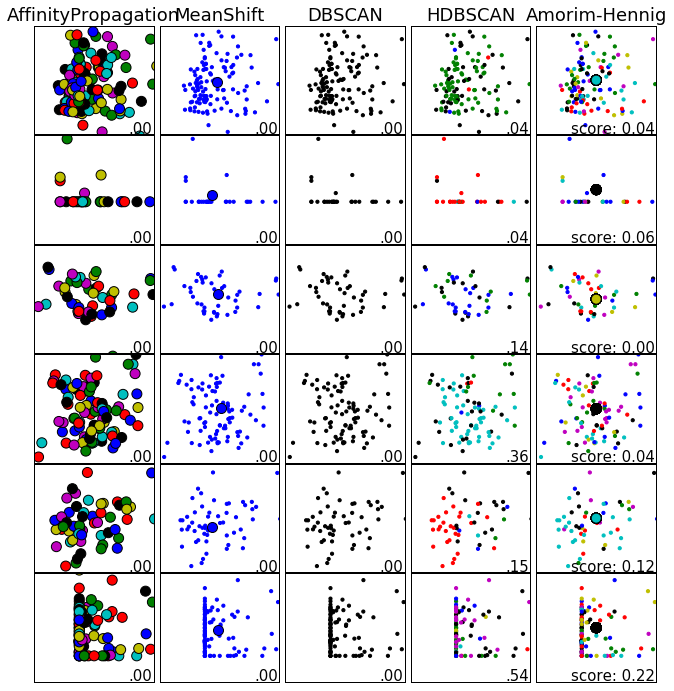

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import urllib.request
from glob import glob

from sklearn import cluster
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import hdbscan as hd
from Analysis.Cluster.Clusterer import IMWKRescaled


import warnings
warnings.filterwarnings('ignore')

# Data from http://portals.broadinstitute.org/cgi-bin/cancer/datasets.cgi

# load data
datasets = []
labels = []
for file in glob('./raw_data/*.gct'):
    print(file)
    data = np.genfromtxt(file, skip_header=4, missing_values=0)
    data = np.delete(data, [0,1], 1)
    data = data.transpose()
    datasets.append(data)
    file = file.replace('gct', 'cls')
    label = np.genfromtxt(file, skip_header=2)
    labels.append(label)

colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)

clustering_names = [
    'AffinityPropagation', 'MeanShift', 'DBSCAN']

plt.figure(figsize=(len(clustering_names) * 2 + 3, 9.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

for i_dataset, dataset in enumerate(datasets):
    X = dataset
    y = labels[i_dataset]
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X,)

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(X, n_neighbors=10, include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # create clustering estimators
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    dbscan = cluster.DBSCAN(eps=.2)
    affinity_propagation = cluster.AffinityPropagation(damping=.9,
                                                       preference=-200)



    clustering_algorithms = [ affinity_propagation, ms, dbscan]

    for name, algorithm in zip(clustering_names, clustering_algorithms):
        # predict cluster memberships
        algorithm.fit(X)
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)
            
        score = metrics.adjusted_rand_score(y_pred, y)

        # plot
        plot = plt.subplot(len(datasets), len(clustering_algorithms) + 2, plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)
        plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred].tolist(), s=10)

        if hasattr(algorithm, 'cluster_centers_'):
            centers = algorithm.cluster_centers_
            center_colors = colors[:len(centers)]
            plt.scatter(centers[:, 0], centers[:, 1], s=100, c=center_colors)
        plt.xlim(-2, 2)
        plt.ylim(-2, 2)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2f' % (score)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1
        
    # Also do HDBSCAN and A-H
    # HDBSCAN 
    algorithm = hd.HDBSCAN(min_cluster_size=2)
    y_pred = algorithm.fit_predict(X)
    score = metrics.adjusted_rand_score(y_pred, y)
    plot = plt.subplot(len(datasets), len(clustering_algorithms) + 2, plot_num)
    if i_dataset == 0:
        plt.title('HDBSCAN', size=18)
    plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred].tolist(), s=10)

    if hasattr(algorithm, 'cluster_centers_'):
        centers = algorithm.cluster_centers_
        center_colors = colors[:len(centers)]
        plt.scatter(centers[:, 0], centers[:, 1], s=100, c=center_colors)
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.xticks(())
    plt.yticks(())
    plt.text(.99, .01, ('%.2f' % (score)).lstrip('0'),
                transform=plt.gca().transAxes, size=15,
                horizontalalignment='right')
    plot_num += 1
    
    # A-H 
    algorithm = IMWKRescaled(X)
    y_pred, centers = algorithm.fit()
    score = metrics.adjusted_rand_score(y_pred, y)
    plot = plt.subplot(len(datasets), len(clustering_algorithms) + 2, plot_num)
    if i_dataset == 0:
        plt.title('Amorim-Hennig', size=18)
    plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred].tolist(), s=10)

        
    center_colors = colors[:len(centers)]
    plt.scatter(centers[:, 0], centers[:, 1], s=100, c=center_colors)
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.xticks(())
    plt.yticks(())
    plt.text(.99, .01, ('score: %.2f' % (score)).lstrip('0'),
                transform=plt.gca().transAxes, size=15,
                horizontalalignment='right')
    plot_num += 1

plt.show()

In [2]:
len(datasets)

6

### References
[1] Mardis, E. R. (2008). The impact of next-generation sequencing technology on genetics. Trends in Genetics, 24(3), 133–141. http://doi.org/10.1016/j.tig.2007.12.007
[2] Melvin, R. L., Godwin, R. C., Xiao, J., Thompson, W. G., Berenhaut, K. S., Salsbury, F. R. Uncovering large-scale conformational change in molecular dynamics without prior knowledge. Journal Of Chemical Theory and Computation. Submitted.
[3] Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., … Duchesnay, É. (2012). Scikit-learn: Machine Learning in Python, 12, 2825–2830. Retrieved from http://arxiv.org/abs/1201.0490
[4] Hubert, L., & Arabie, P. (1985). Comparing partitions. Journal of Classification, 2(1), 193–218. http://doi.org/10.1007/BF01908075